Total bits generated: 320


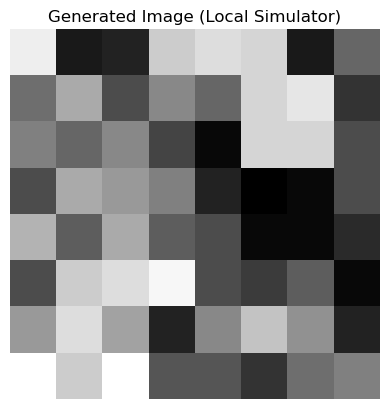

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

n_qubits = 5
q_depth = 4
n_generators = 4
#n_generators = 1
n_a_qubits = 1  
PATCH_SIZE = 2 ** (n_qubits - n_a_qubits)
IMAGE_SIZE = 8  
#PATCH_SIZE = 16
'uncomment and load in key'
#api_key = np.load('api_key.npy', allow_pickle=True) #load in api key here


q_weights = np.load("quantum_weights.npy", allow_pickle=True)

dev = qml.device("default.qubit", wires=n_qubits, shots=PATCH_SIZE)
'swap out for qiskit.ibmq to run on real device'
#dev = qml.device("qiskit.ibmq", wires=n_qubits, backend="name on website", token=api_key, shots=PATCH_SIZE)

@qml.qnode(dev)
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits, 2)
    
    for i in range(n_qubits):
        qml.RX(noise[i], wires=i)
        
    for i in range(q_depth):
        for q in range(n_qubits):
            qml.RX(weights[i][q][0], wires=q)
            qml.RZ(weights[i][q][1], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q + 1) % n_qubits])

    return qml.sample(wires=range(n_qubits))


# --- Generate patches locally ---
patches = []

for generator_id in range(n_generators):
    # Random input noise
    noise = np.zeros(n_qubits)

    # Use weights from trained generator
    weights = q_weights[generator_id]

    # Get output samples (bitstrings)
    samples = quantum_circuit(noise, weights)  # shape: [PATCH_SIZE, n_qubits]

    # Flatten samples across all qubits (this gives one patch per generator)
    patch = samples.flatten()

    patches.append(patch)

flat_image = np.concatenate(patches)  # Concatenate all patches into a flat image
print(f"Total bits generated: {flat_image.size}")  # Make sure the total number of bits is 320

# Reshape to an array of (64, 5) - 64 pixels, each with 5 bits
pixels_5bits = flat_image.reshape((IMAGE_SIZE * IMAGE_SIZE, 5))

# Map each 5-bit group into a value between 0-31 (5 bits -> 0 to 31)
pixel_values = []
for pixel in pixels_5bits:
    # Convert the 5 bits to an integer value between 0 and 31
    bit_value = sum([bit * (2**i) for i, bit in enumerate(pixel[::-1])])  # Convert bits to int
    pixel_values.append(bit_value)

# Normalize to 0-255 for grayscale intensity
grayscale_pixels = np.array(pixel_values) * (255 // 31)  # Scale between 0 and 255

# Reshape into 8x8 image
image = grayscale_pixels.reshape(IMAGE_SIZE, IMAGE_SIZE)

# --- Display the image ---
plt.imshow(image, cmap="gray")
plt.title("Generated Image (Local Simulator)")
plt.axis("off")
plt.show()
